# IMAGINE model library demo

In this short demo, we illustrate the interface of the model library. 


In [13]:
import ImagineModels as img
import numpy as np
import matplotlib.pyplot as plt
from model_examples.plotting_helpers import plot_slice

plt.ion()

### 1.) Model initialization and evaluation at position

All models are implemented as classes with a similar interface. 
The simplest way to initialize such class (in this case the [Jansson & Farrar](https://ui.adsabs.harvard.edu/abs/2012ApJ...757...14J/abstract) model) is via

In [14]:
jf12 = img.JF12RegularField()

All models assume a Galacto-centric coordinate system in units of kiloparsec.
They can be evaluated at a position via the `at_position` member function:

In [15]:
position = [2, -2, 0.1]
bfield_at_position = jf12.at_position(*position)
print(bfield_at_position)

(0.32188229898803716, -0.13192063657348066, -1.7165051848966735)


### 2.) Evaluation on grid

Alternatively, one may evaluate the model on a regular grid via the `on_grid` member function.
For this, one needs to specify the number of cells, the cell increment and the zeropoint (i.e. the location of the point with the smallest coordinate value in all directions, again in Galacto-centric coordinates). 
The output will  

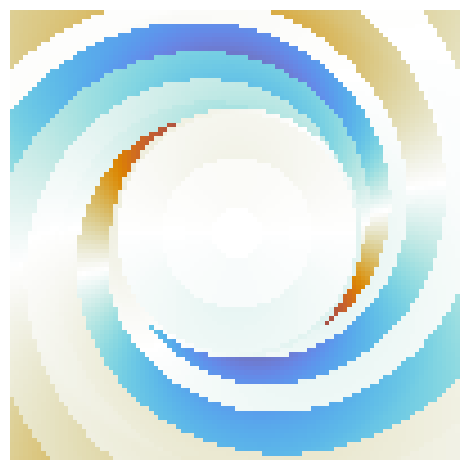

In [16]:
shape = [100, 100, 1] # necessarily a list of 3 ints! 
increment = [.18, .18, .001]  
refpoint = [-9., -9., 0.]

bfield_on_regular_grid = jf12.on_grid(shape=shape, reference_point=refpoint, increment=increment)

plot_slice(bfield_on_regular_grid, 0, 2, shape, refpoint, increment, -3, 3, show_cbar=False, show_labels=False, save_fig=False)

A third possibility to evaluate the model is on an irregular grid. 
For this, one needs to specify the x, y and z coordinates in separate arrays: 

In [17]:
x_coordinates = np.asarray([-10, -9.5, 2])
y_coordinates = np.asarray([-5, -2, 0, .4])
z_coordinates = np.asarray([-.1, 0, .1])

bfield_on_irregular_grid = jf12.on_grid(x_coordinates, y_coordinates, z_coordinates)

### 3.) Model parameters 

The model parameters are implemented as attributes of the classes:

In [18]:
print(jf12.b_arm_1 )

0.1


One can simply update the model parameters via  

In [19]:
jf12.b_arm_1  = 3.14
print(jf12.b_arm_1)

3.14


### 4.) Jacobian w.r.t to model parameters

The models can be differentiated w.r.t. to their model parameters at a position. 
This is useful for numerical optimization schemes that are based gradients.

In [20]:
differentiable_parameters = jf12.active_diff
val = jf12.derivative(0., 1., 0.)
# filtering parameters where the derivative is effectively 0
derivative = {key: [val[0][i], val[1][i], val[2][i]]  for i, key in enumerate(differentiable_parameters) if  sum([val[0][i], val[1][i], val[2][i]]) > 1e-15} 
print(derivative)

{'Xtheta_const': [0.4844405180247598, -2.9663426488815384e-17, 0.0], 'b_arm_2': [2.6558588757141912e-33, 4.337346698759681e-17, 0.7083424709523612], 'B0_X': [1.4526695396296408e-33, 2.372389395278779e-17, 0.3874405905328016]}


## 5.) Alternative initialization

It is also possible to initialize the models directly with the grid parameters, either regular or irregular: 

In [21]:
jaffe_regular = img.JaffeMagneticField(shape, refpoint, increment)
jaffe_irregular = img.JaffeMagneticField(x_coordinates, y_coordinates, z_coordinates)

The grid can then be evaluated via 

In [22]:
bfield_on_regular_grid = jaffe_regular.on_grid()

Other grids can still be passed directly to `on_grid`. 

In the case of the Jaffe model, there is no immediate advantage of passing the grid to the member function or initializing the model with it, apart from maybe more structured code in the latter case. 

For some models, however, initializing the model with the grid maybe advantageous, as some components may be precomputed, resulting in a potentially significant speed advantage.   

### 6.) Random models

Random models (i.e. models which have many degrees of freedom which are not directly accessible, but are drawn from some probability distribution) have the same interface as regular models with some restrictions: 

1. Irregular grids are not supported, due to the fact that the models make use of Fast Fourier Transforms (FFTs).
2. Evaluation at a single position is (not yet) supported.

This only leaves the possibility to evaluate these models on a regular grid. Since random models rely on the FFTW3 module, 
initializing the models with the grid may result in somewhat faster evaluation, as this allows the precomputation of fftw `wisdom'. 
Of course this implies longer initialization.

In [ ]:
import time
random_seed = 23

grid_shape = [20, 30, 40] # again necessarily a list of 3 ints! 
increment = [.2, .3, .01]  
zeropoint = [-10, -5, -.2]

start = time.time()
jf12_random_1 = img.JF12RandomField() # intialize without grid
end = time.time()
print('Case 1: Init without grid: ',  end - start)

start = time.time()
jf12_random_1.on_grid(shape=grid_shape, reference_point=refpoint, increment=increment, seed=23)
end = time.time()
print('Case 1: Filled grid in: ',  end - start)

start = time.time()
jf12_random_2 = img.JF12RandomField(grid_shape, zeropoint, increment) # intialize with grid
end = time.time()
print('Case 2: Init with grid: ',  end - start)

start = time.time()
jf12_random_2.on_grid(random_seed)
end = time.time()
print('Case 2: Filled grid in: ',  end - start)


: 

This makes it evident, that the first case is preferable if the on_grid function is called only a few times, while the latter case will give a speed advantage with many calls.